In [42]:
# Khai báo các thư viện 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

# Cấu hình ngưỡng học máy 
BRIGHT_PIXEL_THRESHOLD = 240   
BRIGHT_RATIO_THRESHOLD = 0.25
IMG_SIZE = 224  
BATCH_SIZE = 32
EPOCHS = 10

train_dir = 'data/train'
val_dir = 'data/valid'        
test_dir = 'data/test'

print(f"TensorFlow Version: {tf.__version__}")
print("Đã sẵn sàng để xử lý dữ liệu")

TensorFlow Version: 2.20.0
Đã sẵn sàng để xử lý dữ liệu


In [2]:
# Kiểm tra ảnh có bị chói không
def is_overexposed_tf(img_path):
    try:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        gray = tf.image.rgb_to_grayscale(img)

        bright_ratio = tf.reduce_mean(
            tf.cast(gray > BRIGHT_PIXEL_THRESHOLD, tf.float32)
        ).numpy()

        return bright_ratio > BRIGHT_RATIO_THRESHOLD, bright_ratio

    except Exception:
        return False, 0.0

In [5]:
#Scan bright images in training set
report = {}

for cls in os.listdir(train_dir): # Đã đổi thành train_dir từ Cell 1
    cls_path = os.path.join(train_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    bad_count = 0
    total = 0

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        total += 1
        is_bad, _ = is_overexposed_tf(img_path)
        if is_bad:
            bad_count += 1

    report[cls] = (bad_count, total)
    print(f"{cls}: {bad_count}/{total} ảnh chói")

Apple___Apple_scab: 0/2016 ảnh chói
Apple___Black_rot: 0/1987 ảnh chói
Apple___Cedar_apple_rust: 202/1760 ảnh chói
Apple___healthy: 1/2008 ảnh chói
Blueberry___healthy: 183/1816 ảnh chói
Cherry_(including_sour)___healthy: 0/1826 ảnh chói
Cherry_(including_sour)___Powdery_mildew: 0/1683 ảnh chói
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0/1642 ảnh chói
Corn_(maize)___Common_rust_: 0/1907 ảnh chói
Corn_(maize)___healthy: 0/1859 ảnh chói
Corn_(maize)___Northern_Leaf_Blight: 0/1908 ảnh chói
Grape___Black_rot: 0/1888 ảnh chói
Grape___Esca_(Black_Measles): 0/1920 ảnh chói
Grape___healthy: 2/1692 ảnh chói
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 0/1722 ảnh chói
Orange___Haunglongbing_(Citrus_greening): 0/2010 ảnh chói
Peach___Bacterial_spot: 0/1838 ảnh chói
Peach___healthy: 281/1728 ảnh chói
Pepper,_bell___Bacterial_spot: 0/1913 ảnh chói
Pepper,_bell___healthy: 205/1988 ảnh chói
Potato___Early_blight: 0/1939 ảnh chói
Potato___healthy: 125/1824 ảnh chói
Potato___Late_blight: 0/193

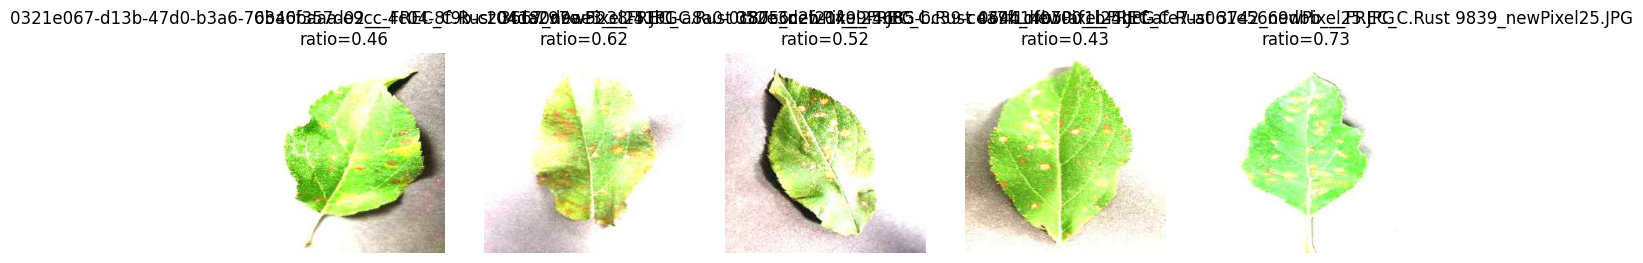

In [7]:
# Hiển thị một số ảnh chói trong tập huấn luyện
import matplotlib.pyplot as plt

def show_bright_images_train(cls, max_show=5):
    cls_path = os.path.join(train_dir, cls) 

    shown = 0
    plt.figure(figsize=(15, 5))

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        is_bad, ratio = is_overexposed_tf(img_path)

        if is_bad:
            img = tf.image.decode_jpeg(tf.io.read_file(img_path))
            plt.subplot(1, max_show, shown + 1)
            plt.imshow(img)
            plt.title(f"{img_name}\nratio={ratio:.2f}")
            plt.axis("off")

            shown += 1
            if shown >= max_show:
                break

    plt.show()
show_bright_images_train("Apple___Cedar_apple_rust")

In [8]:
# Di chuyển ảnh chói vào thư mục riêng
import shutil
MOVE_BAD = True

BAD_DIR = "./bad_images/train"
os.makedirs(BAD_DIR, exist_ok=True)

if MOVE_BAD:
    moved = 0
    for cls in os.listdir(train_dir): 
        cls_path = os.path.join(train_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        cls_bad_dir = os.path.join(BAD_DIR, cls)
        os.makedirs(cls_bad_dir, exist_ok=True)

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            is_bad, _ = is_overexposed_tf(img_path)

            if is_bad:
                shutil.move(img_path, os.path.join(cls_bad_dir, img_name))
                moved += 1

    print(f"Đã move {moved} ảnh chói khỏi train")

Đã move 1941 ảnh chói khỏi train


In [49]:
# Data Genarator
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen_eff = train_datagen_eff.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen_eff = val_datagen_eff.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen_eff = val_datagen_eff.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen_eff.num_classes



Found 68354 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


In [50]:
#   Xây dựng mô hình học sâu sử dụng EfficientNetB0
base_model_eff = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model_eff.trainable = False

In [51]:
# Thêm các lớp tùy chỉnh vào mô hình
x = base_model_eff.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model_eff = Model(inputs=base_model_eff.input, outputs=outputs)

In [52]:
# Compile mô hình và Train
model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_eff.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,392,393 (16.76 MB)

 Trainable params: 340,262 (1.30 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# Bắt đầu train mô hình
history_eff = model_eff.fit(
    train_gen_eff,
    epochs=EPOCHS,
    validation_data=val_gen_eff
)

Epoch 1/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1489s 694ms/step - accuracy: 0.8058 - loss: 0.6521 - val_accuracy: 0.9283 - val_loss: 0.2245
Epoch 2/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1308s 612ms/step - accuracy: 0.8757 - loss: 0.3963 - val_accuracy: 0.9388 - val_loss: 0.1786
Epoch 3/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1344s 629ms/step - accuracy: 0.8856 - loss: 0.3639 - val_accuracy: 0.9471 - val_loss: 0.1614
Epoch 4/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1335s 625ms/step - accuracy: 0.8898 - loss: 0.3447 - val_accuracy: 0.9467 - val_loss: 0.1554
Epoch 5/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1284s 601ms/step - accuracy: 0.8949 - loss: 0.3314 - val_accuracy: 0.9522 - val_loss: 0.1498
Epoch 6/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1272s 595ms/step - accuracy: 0.8990 - loss: 0.3188 - val_accuracy: 0.9442 - val_loss: 0.1621
Epoch 7/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1284s 601ms/step - accuracy: 0.9001 - loss: 0.3151 - val_accuracy: 0.9533 - val_loss: 0.1474
Epoch 8/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1302s 609ms/s

In [56]:
# Fine-tuning 30 layer cuối giúp tăng accuracy
base_model_eff.trainable = True

for layer in base_model_eff.layers[:-30]:
    layer.trainable = False

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history_eff_finetune = model_eff.fit(
    train_gen_eff,
    epochs=EPOCHS,
    validation_data=val_gen_eff
)

Epoch 1/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1737s 809ms/step - accuracy: 0.9804 - loss: 0.0607 - val_accuracy: 0.9862 - val_loss: 0.0455
Epoch 2/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1498s 701ms/step - accuracy: 0.9811 - loss: 0.0587 - val_accuracy: 0.9873 - val_loss: 0.0453
Epoch 3/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1448s 678ms/step - accuracy: 0.9837 - loss: 0.0492 - val_accuracy: 0.9876 - val_loss: 0.0443
Epoch 4/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1515s 709ms/step - accuracy: 0.9831 - loss: 0.0515 - val_accuracy: 0.9871 - val_loss: 0.0456
Epoch 5/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1434s 671ms/step - accuracy: 0.9852 - loss: 0.0446 - val_accuracy: 0.9880 - val_loss: 0.0447
Epoch 6/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1471s 688ms/step - accuracy: 0.9858 - loss: 0.0437 - val_accuracy: 0.9886 - val_loss: 0.0403
Epoch 7/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1449s 678ms/step - accuracy: 0.9873 - loss: 0.0391 - val_accuracy: 0.9895 - val_loss: 0.0376
Epoch 8/10
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1471s 688ms/s

In [91]:
train_loss_eff, train_acc_eff = model_eff.evaluate(val_gen_eff)
print("EfficientNetB0 Training Accuracy:", train_acc_eff)

model_eff.save("efficientnetb0_transfer_learning.h5")

550/550 ━━━━━━━━━━━━━━━━━━━━ 168s 306ms/step - accuracy: 0.9915 - loss: 0.0303


EfficientNetB0 Training Accuracy: 0.9915205836296082


In [74]:
# Vẽ biểu đồ Accuracy và Loss
def plot_training_history(history, title_suffix=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy' + title_suffix)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss' + title_suffix)

    plt.show()

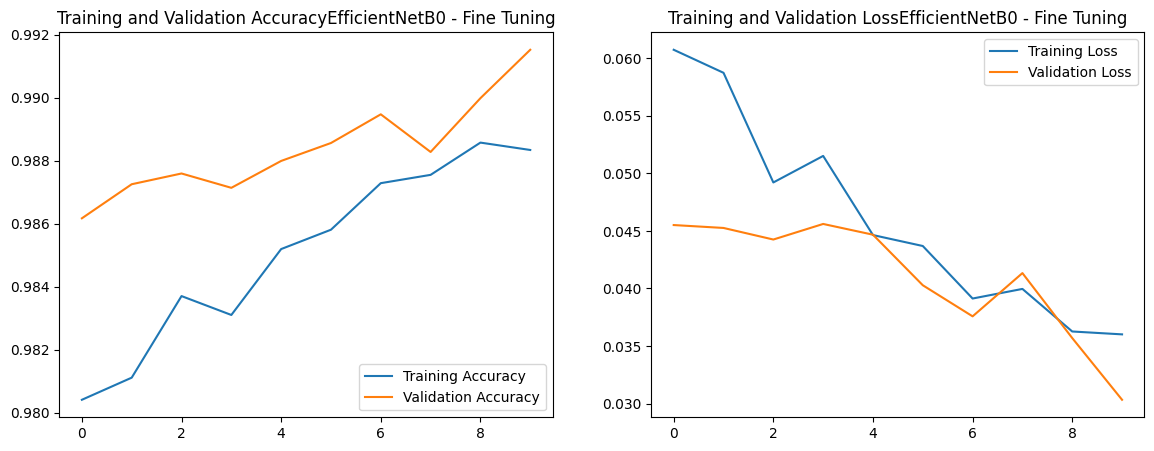

In [ ]:
plot_training_history(history_eff_finetune, "EfficientNetB0 - Fine Tuning")

Found 3503 images belonging to 38 classes.
110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 277ms/step
Validation Accuracy: 0.9877
Validation F1 Score: 0.9877


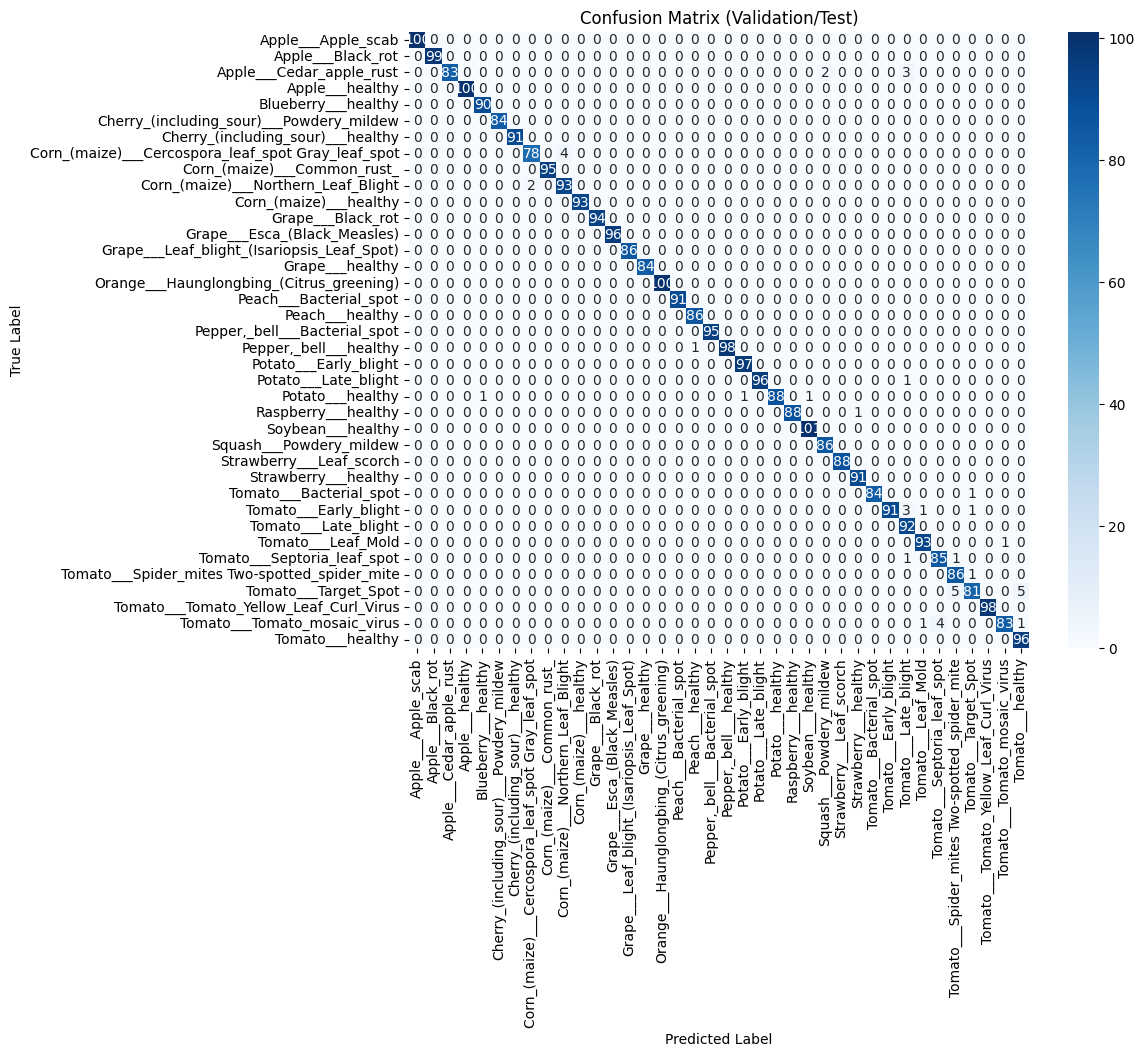

In [35]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

# =========================
DATA_DIR = "./data/valid"
IMG_SIZE = 224
BATCH_SIZE = 32
VAL_SPLIT = 0.2
# =========================
# Tạo validation generator
train_datagen = ImageDataGenerator(validation_split=VAL_SPLIT, preprocessing_function=preprocess_input)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)
Y_true = val_gen.classes
Y_true = val_gen.classes
steps = int(np.ceil(val_gen.samples / val_gen.batch_size))

# Ensure model_eff exists in the current kernel; if not, try to load the saved model file.
if 'model_eff' not in globals():
    try:
        from tensorflow.keras.models import load_model
        model_eff = load_model("efficientnetb0_transfer_learning.h5")
        print("Loaded model_eff from 'efficientnetb0_transfer_learning.h5'")
    except Exception as e:
        raise NameError("model_eff is not defined and loading from 'efficientnetb0_transfer_learning.h5' failed.") from e

Y_pred_probs = model_eff.predict(val_gen, steps=steps, verbose=1)
Y_pred = np.argmax(Y_pred_probs, axis=1)
# Tính accuracy và F1 score
# =========================
acc = accuracy_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# =========================
# Ma trận nhầm lẫn
# =========================
class_names = list(val_gen.class_indices.keys())

cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation/Test)")
plt.show()

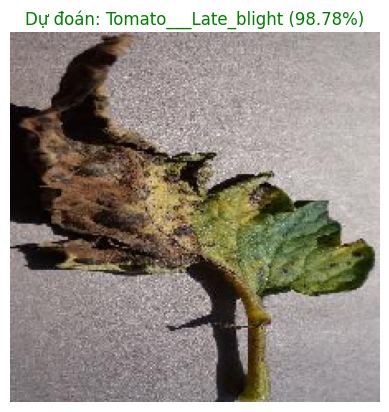

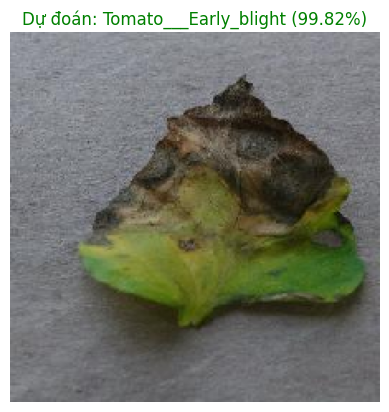

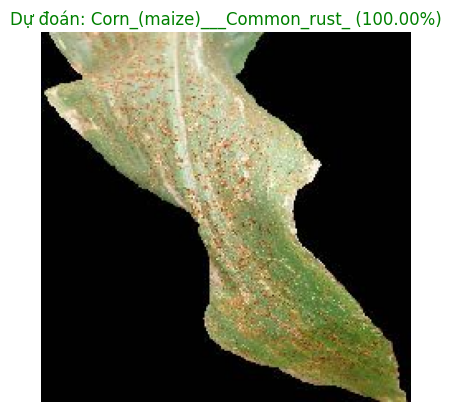

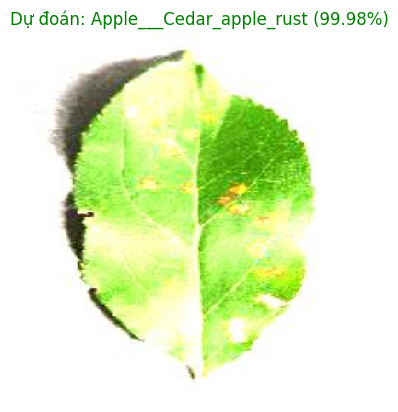

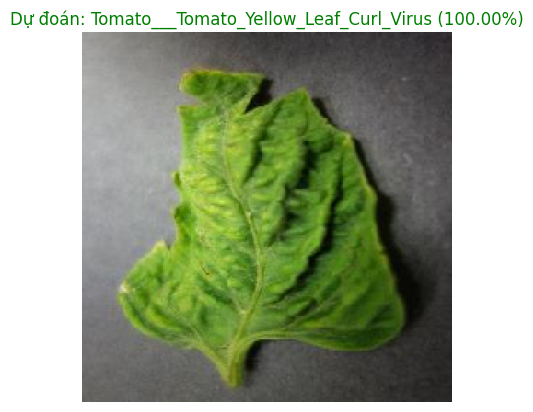

In [46]:
# Test ngẫu nhiên 5 ảnh trong thư mục test
import random   
import os
demo_folder = r"./data/test/test"
# Lấy ngẫu nhiên 5 ảnh
all_files = [f for f in os.listdir(demo_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_files = random.sample(all_files, 5)
for filename in sample_files:
    img_path = os.path.join(demo_folder, filename)
    
    # Load và preprocess
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_arr = img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_input(img_arr)
    # Dự đoán
    preds = model_eff.predict(img_arr, verbose=0)
    label_idx = np.argmax(preds[0])
    confidence = preds[0][label_idx]
    label = class_names[label_idx]
    # Hiển thị ảnh và kết quả dự đoán
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Dự đoán: {label} ({confidence*100:.2f}%)", color="green")
    plt.show()
    